In [1]:
import mc
import fire
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from scipy.stats import pearsonr
from scipy.stats import mode
import scipy.stats as st 
import pandas as pd
import copy
from pathlib import Path
from matplotlib.patches import Patch
import re 
from scipy.stats import binomtest, norm

In [75]:
group_dir_fut_spat = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/spatial_peaks'
trials = 'all_minus_explore'
result_string =f"spatial_consistency_{trials}_repeats_excl_gridwise_qc_pct_neurons_weighted.csv"
perm_result_string = f'pval_for_perms200_spatial_consistency_{trials}_repeats_excl_gridwise_qc_pct_neurons_weighted.csv'

empirical_df = pd.read_csv(f"{group_dir_fut_spat}/{result_string}")
perm_df = pd.read_csv(f"{group_dir_fut_spat}/{perm_result_string}")

In [43]:
perm_df.head()

,Unnamed: 0,session_id,neuron_id,mode_peak_shift,avg_consistency_at_peak,count_mode_peak,perm_idx,mean_firing_rate,sparse_repeats,roi,n_perms,p_perm,sig_FDR_all
0,0,1,01-01-chan99-OFC,150.0,0.117535,1 out of 3,0,5.526398,0,PFC,200.0,0.288557,False
1,1,1,04-04-chan113-EC,30.0,0.172044,1 out of 3,0,0.752580,0,entorhinal,200.0,0.218905,False
2,2,1,05-05-chan116-EC,30.0,0.158614,1 out of 3,0,6.758461,0,entorhinal,200.0,0.228856,False
3,3,1,06-06-chan119-EC,90.0,-0.233378,1 out of 3,0,2.730172,0,entorhinal,200.0,0.900498,False
4,4,1,07-07-chan120-EC,30.0,0.319556,1 out of 3,0,0.845441,0,entorhinal,200.0,0.213930,False


In [27]:
def plot_results_per_roi(df, title_string_add, plot_by_pfc = False, plot_by_cingulate_and_MTL = False):
    
    # --- inputs ---
    p_col = 'p_perm'   # optional column
    alpha_sig = 0.05


    # import pdb; pdb.set_trace()
    df['roi'] = rename_rois(df, collapse_pfc = plot_by_pfc, plot_by_cingulate_and_MTL = plot_by_cingulate_and_MTL)

    # --- rows  ---
    results_list = [
        ('zero lag (330, 0, 30)', df[df["mode_peak_shift"].isin([0, 30, 330])]),
        ('future lags',            df[~df["mode_peak_shift"].isin([0, 30, 330])]),
        ('all lags',               df),
    ]
    
    rois   = df['roi'].unique().tolist()
    n_rows = len(results_list)
    n_cols = len(rois)
    bins   = 20
    title_string_add = title_string_add if 'title_string_add' in locals() else ''
    
    plt.rcParams.update({'font.size': 11})
    
    # Make rows closer: use small hspace. Don't share y → allow 2 different y-scales.
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(8.27, 12.0),     # keep big; height matters more than hspace for readability
        sharex=True, sharey=False,
        gridspec_kw={'hspace': 0.18, 'wspace': 0.3}  # <<< tighter vertical spacing
    )
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)
    
    # Precompute per-row histogram maxima for two y-scales
    row_max_top3, row_max_all = 0, 0
    cache = [[None]*n_cols for _ in range(n_rows)]
    for r, (result_name, df_res) in enumerate(results_list):
        for c, roi in enumerate(rois):
            vals = df_res.loc[df_res['roi'] == roi, 'avg_consistency_at_peak'].to_numpy(float)
            vals = vals[np.isfinite(vals)]
            counts, _ = np.histogram(vals, bins=bins)
            cache[r][c] = (vals, counts)
            mx = counts.max() if counts.size else 0
            if result_name == 'all lags':
                row_max_all = max(row_max_all, mx)
            else:
                row_max_top3 = max(row_max_top3, mx)
    
    # Plot
    for r, (result_name, df_res) in enumerate(results_list):
        for c, roi in enumerate(rois):
            ax = axes[r, c]
            vals, counts = cache[r][c]
    
            ax.hist(vals, bins=bins, color='teal', alpha=0.5, edgecolor='teal')
            ax.axvline(0, color='black', linestyle='dashed', linewidth=1.5)
    
            # stats box (use helpers)
            t_stat, p_one, mval = one_tailed_ttest_greater_than_zero(vals)
            sig = stars(p_one)
            # keep inside but compact; doesn’t add row spacing
            ax.text(0.98, 0.96,
                    f"n={vals.size}\nmean={mval:.2f}\n{sig} (p={p_one:.1e})",
                    transform=ax.transAxes, ha='right', va='top',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                    fontsize=11)
    
            # Column headers (top row only)
            if r == 0:
                ax.set_title(roi, fontsize=11, pad=4)  # smaller pad -> tighter rows
    
            # Row labels (first col only)
            if c == 0:
                ax.text(-0.16, 0.5, result_name, transform=ax.transAxes,
                        ha='right', va='center', rotation=90, fontsize=11)
    
            # Apply the two y-scales
            ylim_max = row_max_all if result_name == 'all lags' else row_max_top3
            ax.set_ylim(0, max(1, int(ylim_max * 1.04)))  # slight squash
    
            ax.tick_params(axis='both', labelsize=11, width=1.1, length=4)
    
    # Shared labels (don’t repeat on each subplot)
    fig.supxlabel("Correlation coefficient", fontsize=11)
    fig.supylabel("Frequency", fontsize=11)
    
    # Tighten outer margins; keep headroom for the suptitle
    fig.subplots_adjust(left=0.08, right=0.97, bottom=0.08, top=0.9, hspace=0.18, wspace=0.3)
    fig.suptitle(f"Mean spatial consistency (cross val) at peak lag per cell, split by ROI \n {title_string_add}",
                 fontsize=12, fontweight='bold', y=0.965)
    
    plt.show()

    
    
    
#
#
#

def plot_results_per_roi(df, title_string_add, plot_by_pfc=False, plot_by_cingulate_and_MTL=False):
    # --- inputs ---
    metric_col = 'state_cv_consistency'
    p_col = 'p_perm'   # optional column
    alpha_sig = 0.05
    bins = 20

    # ROI labels
    df = df.copy()
    df['roi'] = mc.analyse.helpers_human_cells.rename_rois(
        df,
        collapse_pfc=plot_by_pfc,
        plot_by_cingulate_and_MTL=plot_by_cingulate_and_MTL
    )

    rois = df['roi'].dropna().unique().tolist()
    n_cols = len(rois)

    plt.rcParams.update({'font.size': 11})

    # single row, n_cols columns
    fig, axes = plt.subplots(
        1, n_cols,
        figsize=(max(6.5, 2.2 * n_cols), 4.0),
        sharex=True, sharey=True,
        gridspec_kw={'wspace': 0.3}
    )
    if n_cols == 1:
        axes = np.array([axes])
        

    # Precompute common bin edges
    all_vals = df[metric_col].to_numpy(dtype=float)
    all_vals = all_vals[np.isfinite(all_vals)]
    bin_edges = np.histogram_bin_edges(all_vals, bins=bins)

    ylim_max = 0
    per_roi_data = []
    for roi in rois:
        sub = df.loc[df['roi'] == roi]
        vals = sub[metric_col].to_numpy(dtype=float)
        mask_valid = np.isfinite(vals)

        # If p_perm exists, split into significant vs. not
        if p_col in sub.columns:
            pvals = sub[p_col].to_numpy(dtype=float)
            mask_valid &= np.isfinite(pvals)
            vals = vals[mask_valid]
            pvals = pvals[mask_valid]

            sig_mask = pvals < alpha_sig
            vals_sig = vals[sig_mask]
            vals_nonsig = vals[~sig_mask]

            c_sig, _ = np.histogram(vals_sig, bins=bin_edges)
            c_nonsig, _ = np.histogram(vals_nonsig, bins=bin_edges)
            counts = c_sig + c_nonsig
            per_roi_data.append((vals, vals_sig, vals_nonsig))
        else:
            vals = vals[mask_valid]
            counts, _ = np.histogram(vals, bins=bin_edges)
            per_roi_data.append((vals, None, None))

        ylim_max = max(ylim_max, counts.max() if counts.size else 0)

    # plotting
    for ax, roi, vals_tuple in zip(axes, rois, per_roi_data):
        vals_all, vals_sig, vals_nonsig = vals_tuple

        if vals_sig is not None:  # p_perm available
            ax.hist(vals_nonsig, bins=bin_edges,
                    color='lightgray', edgecolor='black', alpha=1.0, label='n.s.')
            ax.hist(vals_sig, bins=bin_edges,
                    color='salmon', edgecolor='black', alpha=0.95, label=f'p<{alpha_sig:.2f}')
        else:  # no p_perm
            ax.hist(vals_all, bins=bin_edges,
                    color='lightgray', edgecolor='black')

        # zero line
        ax.axvline(0, color='k', linestyle='dashed', linewidth=1.3)

        # stats box (based on all vals)
        t_stat, p_one, mval = one_tailed_ttest_greater_than_zero(vals_all)
        sig = stars(p_one)
        ax.text(
            0.98, 0.96,
            f"n={vals_all.size}\nmean={mval:.2f}\n{sig} (p={p_one:.1e})",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
            fontsize=10
        )

        ax.set_title(str(roi), pad=4)
        ax.tick_params(axis='both', labelsize=10, width=1.0, length=4)

    # consistent y-axis
    axes[0].set_ylim(0, max(1, int(ylim_max * 1.04)))

    # shared labels + title
    fig.supxlabel(metric_col)
    fig.supylabel("Frequency")
    fig.suptitle(
        f"Cross-validated state consistency per cell, split by ROI\n{title_string_add}",
        fontsize=12, fontweight='bold', y=0.98
    )

    # add legend only if p_perm was present
    if p_col in df.columns:
        axes[-1].legend(frameon=False, fontsize=9, loc='upper left')

    fig.subplots_adjust(left=0.07, right=0.98, bottom=0.18, top=0.85, wspace=0.3)
    plt.show()
    

    
    

In [36]:
# --- Helpers for stats ---
def one_tailed_ttest_greater_than_zero(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan, np.nan, np.nan  # t, p, mean
    t_stat, p_two = st.ttest_1samp(x, 0.0, nan_policy='omit')
    p_one = p_two / 2 if t_stat > 0 else 1 - (p_two / 2)
    return float(t_stat), float(p_one), float(np.mean(x))

def stars(p):
    if not np.isfinite(p):
        return "n/a"
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'n.s.'

def bh_fdr(pvals):
    """Benjamini–Hochberg adjusted p-values (q-values). NaNs stay NaN."""
    p = np.asarray(pvals, float)
    m = np.sum(~np.isnan(p))
    adj = np.full_like(p, np.nan, dtype=float)
    if m == 0:
        return adj
    # ranks among finite p
    order = np.argsort(np.where(np.isnan(p), np.inf, p))
    ranks = np.arange(1, len(p) + 1, dtype=float)
    # monotone BH
    p_ord = p[order]
    with np.errstate(invalid="ignore"):
        running = np.minimum.accumulate((m / ranks[order]) * p_ord[::-1])[::-1]
    adj[order] = np.clip(running, 0, 1)
    return adj

def rename_rois(df, collapse_pfc = False, plot_by_cingulate_and_MTL = False):
    roi_label = []
    if collapse_pfc == True:
        for _, row in df.iterrows():
            cell_label = row['neuron_id']
            if 'ACC' in cell_label or 'vCC' in cell_label or 'AMC' in cell_label or 'vmPFC' in cell_label or 'OFC' in cell_label:
                roi = 'PFC'
            elif 'MCC' in cell_label or 'HC' in cell_label:
                roi = 'hippocampal'
            elif 'EC' in cell_label:
                roi = 'entorhinal'
            elif 'AMYG' in cell_label:
                roi = 'amygdala'
            elif 'PCC' in cell_label:
                roi = 'PCC'
            else:
                roi = 'mixed'
            roi_label.append(roi)
    elif plot_by_cingulate_and_MTL == True:
        for _, row in df.iterrows():
            cell_label = row['neuron_id']
            if 'ACC' in cell_label or 'vCC' in cell_label or 'AMC' in cell_label or 'vmPFC' in cell_label or 'PCC' in cell_label:
                roi = 'Cingulate'
            elif 'MCC' in cell_label or 'HC' in cell_label or 'EC' in cell_label or 'AMYG' in cell_label:
                roi = 'MTL'
            elif 'OFC' in cell_label:
                roi = 'OFC'
            else:
                roi = 'mixed'
            roi_label.append(roi)
    else:
        for _, row in df.iterrows():
            cell_label = row['neuron_id']
            if 'ACC' in cell_label or 'vCC' in cell_label or 'AMC' in cell_label or 'vmPFC' in cell_label:
                roi = 'ACC'
            elif 'PCC' in cell_label:
                roi = 'PCC'
            elif 'OFC' in cell_label:
                roi = 'OFC'
            elif 'MCC' in cell_label or 'HC' in cell_label:
                roi = 'hippocampal'
            elif 'EC' in cell_label:
                roi = 'entorhinal'
            elif 'AMYG' in cell_label:
                roi = 'amygdala'
            else:
                roi = 'mixed'
            roi_label.append(roi)
    return roi_label

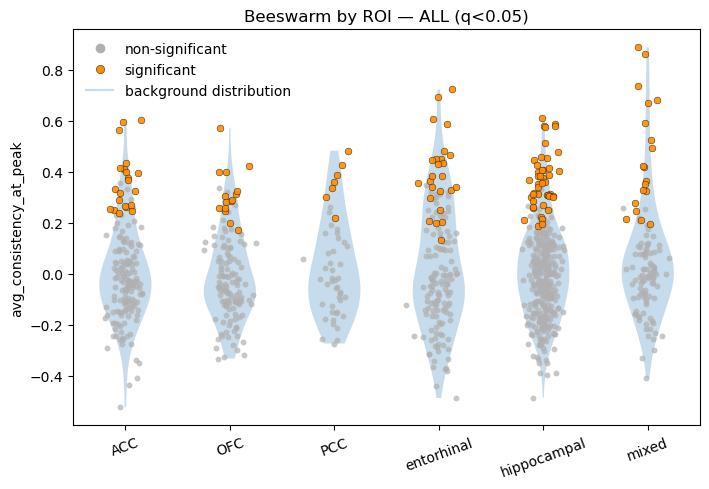

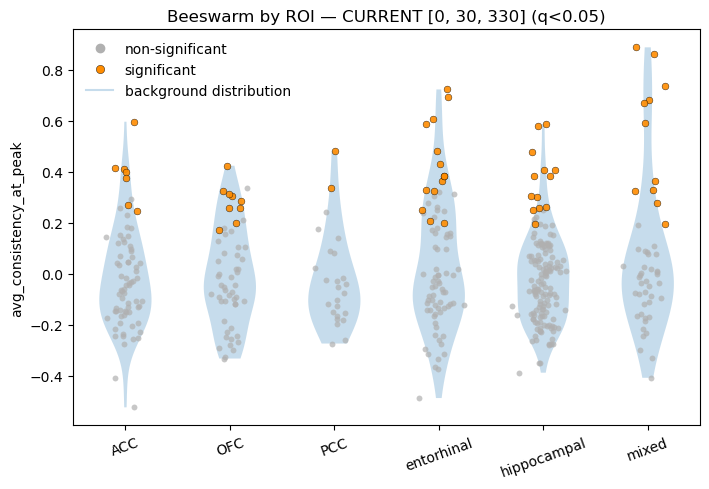

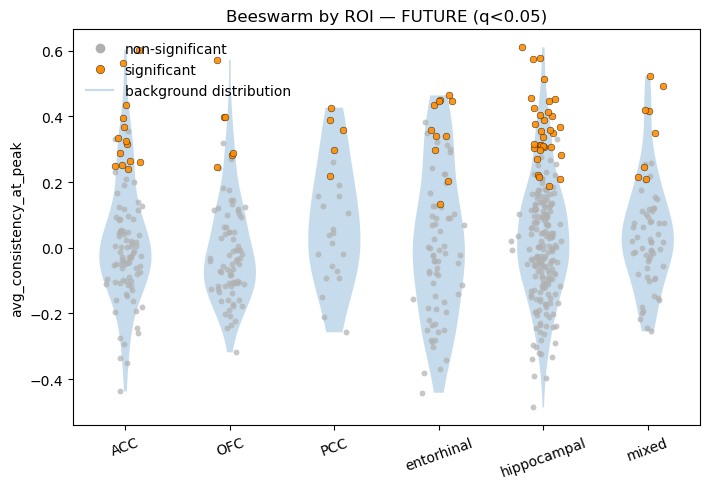

In [5]:
perm_string = f"pval_for_perms200_{result_string}"
name_result_stats = f"{group_dir_fut_spat}/{perm_string}"

mc.plotting.results.plot_perm_spatial_consistency(perm_df, empirical_df, name_result_stats, group_dir_fut_spat)

           

In [8]:
 # define what counts as "now"
NOW_SET = {330, 0, 30}
# masks
shift_int   = perm_df["mode_peak_shift"]
mask_now    = shift_int.isin(NOW_SET)
mask_future = shift_int.notna() & ~mask_now


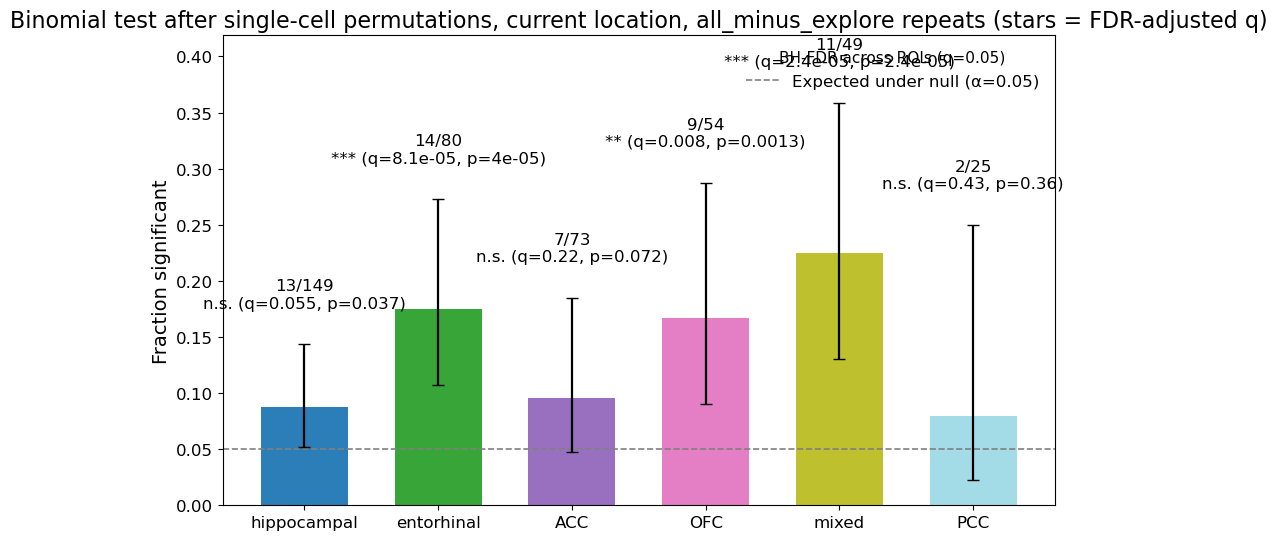

In [17]:
# run your existing binomial-per-ROI plot twice
title_string_now = f'Binomial test after single-cell permutations, current location, {trials} repeats'
tbl_now = plt_binomial_per_roi(perm_df[mask_now],
                     title_string_now,
                     alpha=0.05, use_fdr=True, fdr_q=0.05)

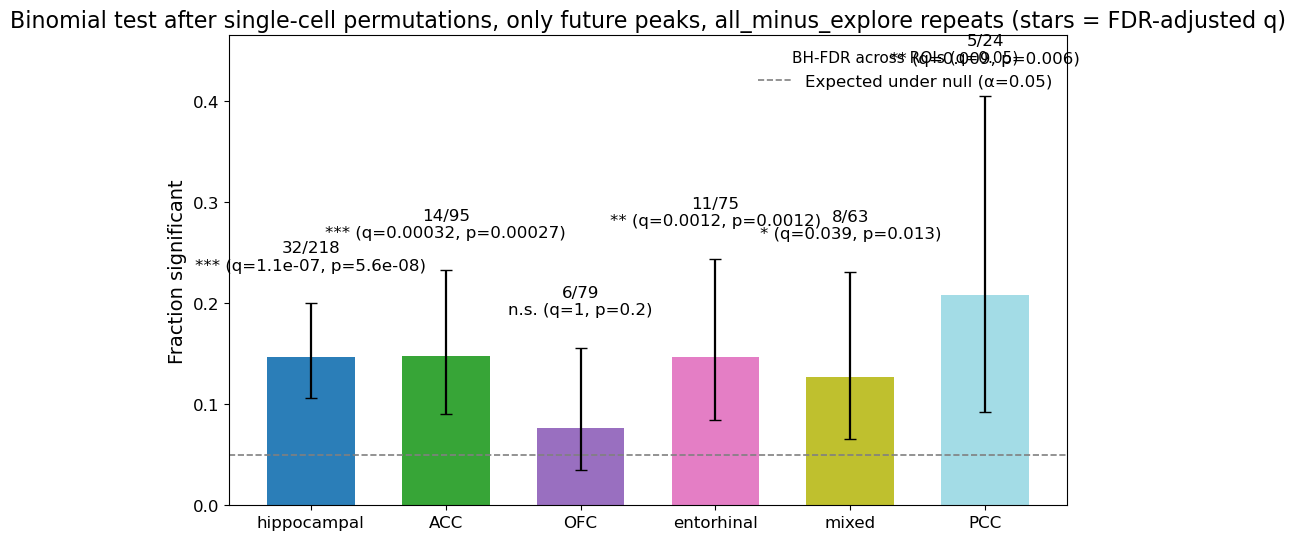

In [20]:
title_string_future = f'Binomial test after single-cell permutations, only future peaks, {trials} repeats' 
tbl_future = plt_binomial_per_roi(perm_df[mask_future],
                                 title_string_future,
                                 alpha=0.05, use_fdr=True, fdr_q=0.05)

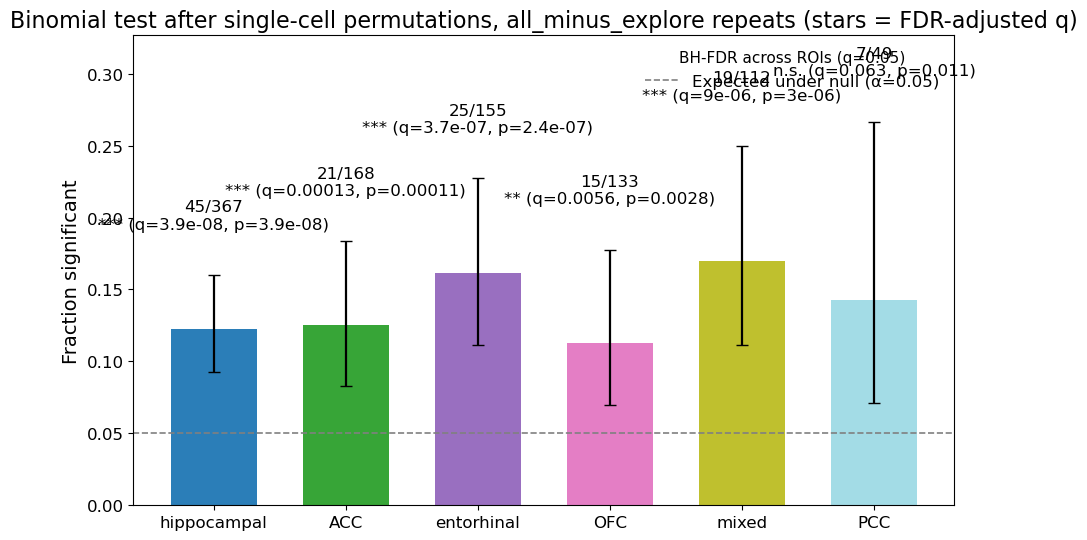

,roi,n,k,frac,ci_lo,ci_hi,p_raw,p_adj
0,hippocampal,367,45,0.122616,0.092914,0.160136,3.864067e-08,3.864067e-08
1,ACC,168,21,0.125000,0.083230,0.183536,1.104095e-04,1.324913e-04
2,entorhinal,155,25,0.161290,0.111701,0.227263,2.440931e-07,3.661397e-07
3,OFC,133,15,0.112782,0.069549,0.177755,2.784349e-03,5.568699e-03
4,mixed,112,19,0.169643,0.111379,0.249817,2.987384e-06,8.962153e-06
5,PCC,49,7,0.142857,0.070964,0.266677,1.058271e-02,6.349628e-02


In [22]:
title_string_all = f'Binomial test after single-cell permutations, {trials} repeats'
plt_binomial_per_roi(perm_df, title_string_all)

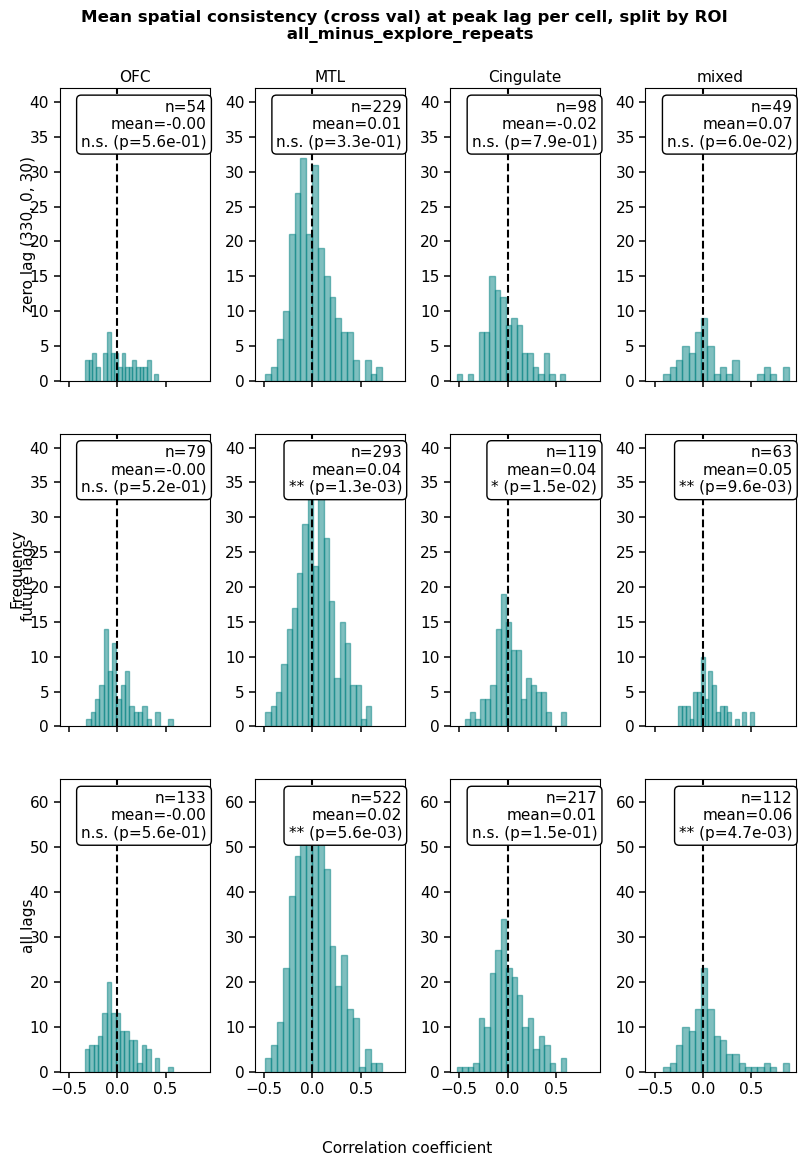

In [28]:
plot_results_per_roi(perm_df, title_string_add = f'{trials}_repeats',plot_by_pfc=False,plot_by_cingulate_and_MTL=True)
#plot_results_per_roi(results_df, title_string_add = f'{trials}_repeats',plot_by_pfc=True,plot_by_cingulate_and_MTL=False)
#plot_results_per_roi(results_df, title_string_add = f'{trials}_repeats',plot_by_pfc=False,plot_by_cingulate_and_MTL=False)

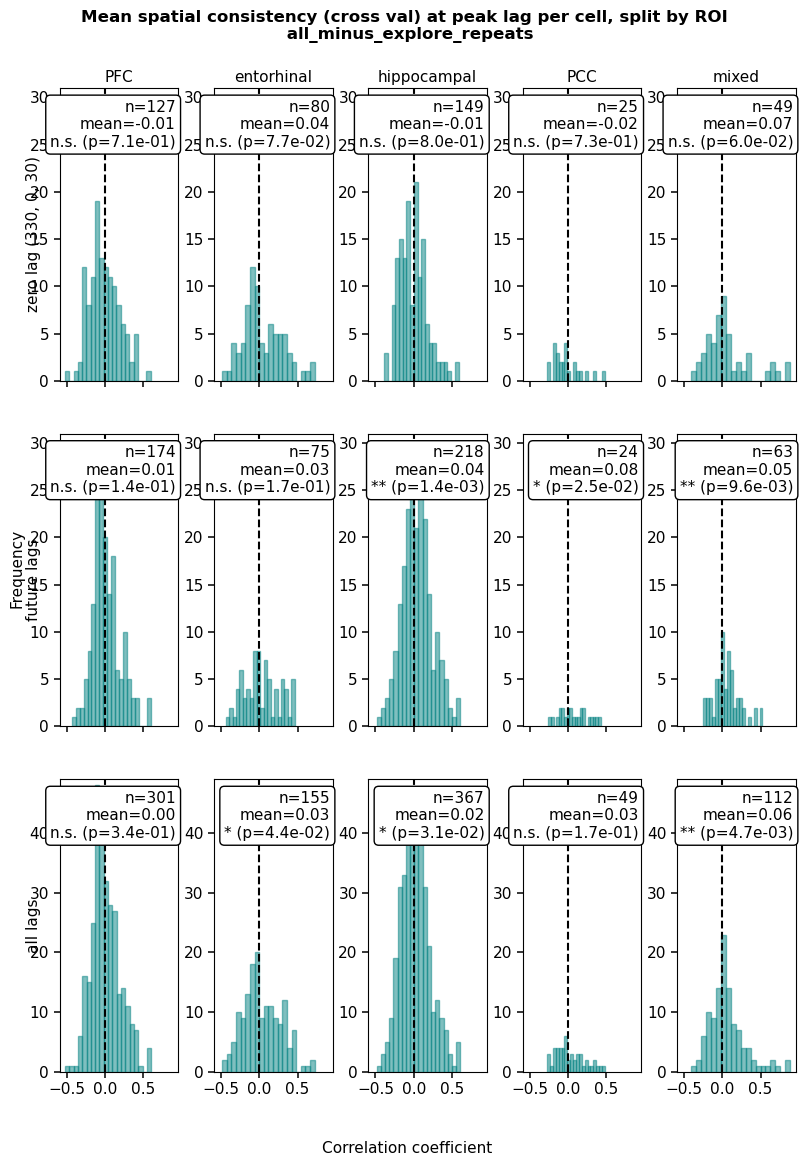

In [38]:
plot_results_per_roi(perm_df, title_string_add = f'{trials}_repeats',plot_by_pfc=True,plot_by_cingulate_and_MTL=False)

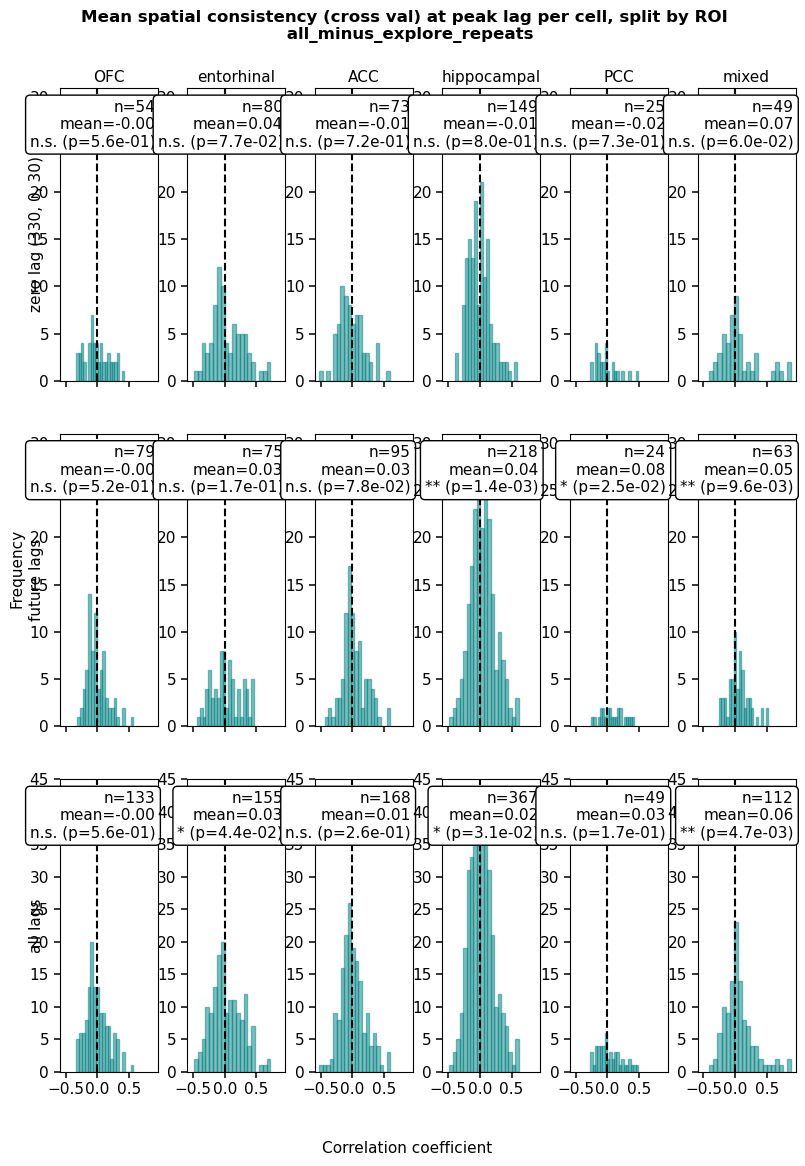

In [37]:
plot_results_per_roi(perm_df, title_string_add = f'{trials}_repeats',plot_by_pfc=False,plot_by_cingulate_and_MTL=False)

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _sorted_rois(rois):
    # deterministic order: first letter, then full name
    return sorted(rois, key=lambda r: (str(r)[0], str(r)))

def plot_results_per_roi_sorted(
    df: pd.DataFrame,
    title_string_add: str,
    *,
    roi_col: str = "roi",
    lag_col: str = "mode_peak_shift",
    metric_col: str = "avg_consistency_at_peak",
    p_col: str = "p_perm",           # set None if no p-values
    alpha_sig: float = 0.05,
    zero_lag_values = (0, 30, 330),
    bins: int = 20,
    rename_rois_fn=None,             # function(df)->df that returns a DF with a (possibly) new roi_col
    debug_assert: bool = False,
):
    """
    Three rows: zero-lag / future-lags / all-lags.
    - Everything stays in DataFrames until the last possible step.
    - ROI order is fixed and used consistently (ordered Categorical).
    - Significant bars in red if p_col present.
    """

    # 1) Copy and (optionally) rename/collapse ROIs IN-DF
    df = df.copy()
    if rename_rois_fn is not None:
        df = rename_rois_fn(df)  # must return a DF; keeps column names stable

    # 2) Basic checks
    for col in (roi_col, lag_col, metric_col):
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # 3) Establish a SINGLE canonical ROI order and lock it in
    rois_order = _sorted_rois(df[roi_col].dropna().unique().tolist())
    df[roi_col] = pd.Categorical(df[roi_col], categories=rois_order, ordered=True)

    # 4) Define rows purely as DF filters
    zero_mask   = df[lag_col].isin(zero_lag_values)
    future_mask = ~zero_mask
    row_specs = [
        ("zero lag (330, 0, 30)", df.loc[zero_mask]),
        ("future lags",           df.loc[future_mask]),
        ("all lags",              df),
    ]

    # 5) Set up figure
    n_rows, n_cols = len(row_specs), len(rois_order)
    plt.rcParams.update({'font.size': 11})
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(max(9.0, 2.6 * n_cols), 11.5),
        sharex=True, sharey=False,
        gridspec_kw={'hspace': 0.22, 'wspace': 0.35}
    )
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    row_ymax = np.zeros(n_rows, dtype=int)
    row_edges = [None]*n_rows

    # 6) Precompute row-wise bin edges and row-wise ymax using the SAME DF slices we’ll plot
    for r, (_row_name, df_row) in enumerate(row_specs):
        vals_row = df_row[metric_col].astype(float)
        vals_row = vals_row[np.isfinite(vals_row)]
        edges = np.histogram_bin_edges(vals_row.values, bins=bins) if len(vals_row) else np.linspace(-1,1,bins+1)
        row_edges[r] = edges

        # compute ymax by iterating ROIs using DF slices (no caching by arrays)
        for roi in rois_order:
            sub = df_row.loc[df_row[roi_col] == roi, [metric_col] + ([p_col] if p_col and p_col in df_row.columns else [])]
            sub = sub.dropna(subset=[metric_col])
            if sub.empty:
                continue
            if p_col and (p_col in sub.columns):
                sig_mask = (sub[p_col] < alpha_sig) & np.isfinite(sub[p_col])
                c_sig, _    = np.histogram(sub.loc[sig_mask,  metric_col].values, bins=edges)
                c_nonsig, _ = np.histogram(sub.loc[~sig_mask, metric_col].values, bins=edges)
                counts = c_sig + c_nonsig
            else:
                counts, _ = np.histogram(sub[metric_col].values, bins=edges)
            row_ymax[r] = max(row_ymax[r], int(counts.max()) if counts.size else 0)

    # 7) Plot directly from DF slices (one ROI-at-a-time, one row-at-a-time)
    for r, (row_name, df_row) in enumerate(row_specs):
        edges = row_edges[r]
        for c, roi in enumerate(rois_order):
            ax = axes[r, c]

            sub = df_row.loc[df_row[roi_col] == roi, [roi_col, metric_col] + ([p_col] if p_col and p_col in df_row.columns else [])]
            sub = sub.dropna(subset=[metric_col])

            if debug_assert:
                # assert the slice truly is a single ROI
                assert sub[roi_col].nunique() <= 1, f"ROI mismatch at row {r}, col {c}"

            # split sig / non-sig ALL in DF space
            if (p_col is not None) and (p_col in sub.columns):
                sig_mask = (sub[p_col] < alpha_sig) & np.isfinite(sub[p_col])
                vals_nonsig = sub.loc[~sig_mask, metric_col].astype(float).values
                vals_sig    = sub.loc[ sig_mask, metric_col].astype(float).values

                ax.hist(vals_nonsig, bins=edges, color='lightgray',
                        edgecolor='black', linewidth=1.0, alpha=1.0, label='n.s.')
                ax.hist(vals_sig,    bins=edges, color='salmon',
                        edgecolor='black', linewidth=1.0, alpha=0.95, label=f'p<{alpha_sig:.2f}')
                vals_all = sub[metric_col].astype(float).values
            else:
                vals_all = sub[metric_col].astype(float).values
                ax.hist(vals_all, bins=edges, color='lightgray',
                        edgecolor='black', linewidth=1.0, alpha=1.0)

            # zero line
            ax.axvline(0, color='k', linestyle='dashed', linewidth=1.4)

            # stats box (computed from THIS exact DF slice)
            if vals_all.size:
                t_stat, p_one, mval = one_tailed_ttest_greater_than_zero(vals_all)
                sigtxt = stars(p_one)
                ax.text(
                    0.98, 0.96,
                    f"n={vals_all.size}\nmean={mval:.2f}\n{sigtxt} (p={p_one:.1e})",
                    transform=ax.transAxes, ha='right', va='top',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                    fontsize=10
                )
            else:
                ax.text(0.98, 0.96, "n=0",
                        transform=ax.transAxes, ha='right', va='top',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                        fontsize=10)

            # headers / row labels
            if r == 0:
                ax.set_title(str(roi), fontsize=11, pad=5)
            if c == 0:
                ax.text(-0.16, 0.5, row_name, transform=ax.transAxes,
                        ha='right', va='center', rotation=90, fontsize=11)

            # y-limits per row (from prepass)
            ax.set_ylim(0, max(1, int(row_ymax[r] * 1.06)))
            ax.tick_params(axis='both', labelsize=10, width=1.1, length=4)

    # 8) Shared labels + suptitle + legend (only once if used)
    fig.supxlabel("Correlation coefficient", fontsize=11)
    fig.supylabel("Frequency", fontsize=11)
    fig.suptitle(
        f"Mean spatial consistency (cross-val) at peak lag per cell, split by ROI\n{title_string_add}",
        fontsize=12, fontweight='bold', y=0.965
    )
    if (p_col is not None) and (p_col in df.columns):
        axes[0, -1].legend(frameon=False, fontsize=9, loc='upper left')

    fig.subplots_adjust(left=0.08, right=0.98, bottom=0.08, top=0.9, hspace=0.22, wspace=0.35)
    plt.show()


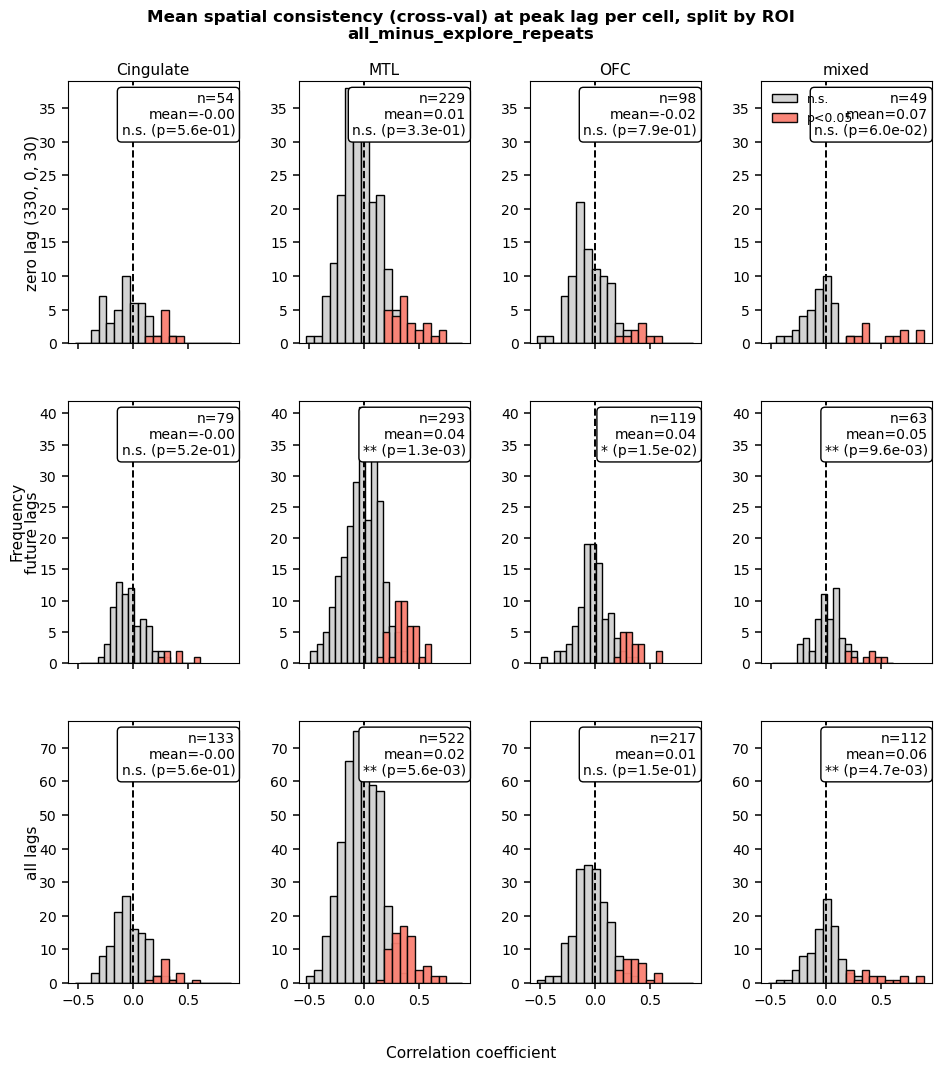

In [58]:
plot_results_per_roi(perm_df, title_string_add = f'{trials}_repeats',plot_by_pfc=False,plot_by_cingulate_and_MTL=True)

In [61]:
df = perm_df.copy()
rois = sorted(np.unique(df['roi'].to_numpy()))


row_specs = [
    ("zero lag (330, 0, 30)", df.loc[zero_mask]),
    ("future lags",           df.loc[future_mask]),
    ("all lags",              df),
]
    

['PCC', 'PFC', 'entorhinal', 'hippocampal', 'mixed']

In [69]:
# --- rows  ---


3

In [90]:
perm_df.head()
# I want to show the difference between future vs. not future cells in ACC
curr_loc = perm_df[perm_df["mode_peak_shift"].isin([0, 30, 330])].copy()
future_loc =  perm_df[~perm_df["mode_peak_shift"].isin([0, 30, 330])].copy()

ACC_curr_loc = curr_loc[curr_loc['roi'] == 'ACC']
ACC_future_loc = future_loc[future_loc['roi'] == 'ACC']

no_all_cells_ACC = len(perm_df[perm_df['roi'] == 'ACC'])

sig_curr = ACC_curr_loc[ACC_curr_loc['p_perm'] < 0.05]
sig_fut = ACC_future_loc[ACC_future_loc['p_perm'] < 0.05]

print(f"there are {len(ACC_future_loc)} future cells, out of which are {len(sig_fut)} significant, or {len(sig_fut)/len(ACC_future_loc)} %; or {len(sig_fut)/no_all_cells_ACC}% of overall ACC cells")
print(f"there are {len(ACC_curr_loc)} current cells, out of which are {len(sig_curr)} significant, or {len(sig_curr)/len(ACC_curr_loc)} %; or {len(sig_curr)/no_all_cells_ACC}% of overall ACC cells")

there are 95 future cells, out of which are 14 significant, or 0.14736842105263157 %; or 0.08333333333333333% of overall ACC cells
there are 73 current cells, out of which are 7 significant, or 0.0958904109589041 %; or 0.041666666666666664% of overall ACC cells


In [99]:
alpha = 0.05
pcol = 'p_perm'  # change if needed

# Example: assume ACC_future_loc and ACC_curr_loc are already in memory
# and each has a column p_perm with per-cell permutation p-values

# --- DERIVE COUNTS ---
n_future = len(ACC_future_loc)
k_future = len(sig_fut)

n_current = len(ACC_curr_loc)
k_current = len(sig_curr)
print(no_all_cells_ACC)

168


In [114]:
for idx, row in sig_fut.iterrows():
    print(row['session_id'])
    print(row['neuron_id'])

3
01-01-GA1-RAC1-ACC
18
08-08-mLF2Ca03-ACC
25
25-25-mRF2Ca06-ACC
25
23-23-mRF2Ca05-ACC
27
02-02-mRF3cVPF01-RPvmPFC
29
09-09-chan105-ACC
35
02-02-mRF3C07-ACC
41
20-20-mRAMCC8-RAMC
42
13-13-mRAMCC6-RAMC
42
12-12-mRAMCC5-RAMC
48
07-07-mRACC5-ACC
61
24-24-mRF2aC03-ACC
61
23-23-mRF2aC03-ACC
62
20-20-mRF2aC04-ACC


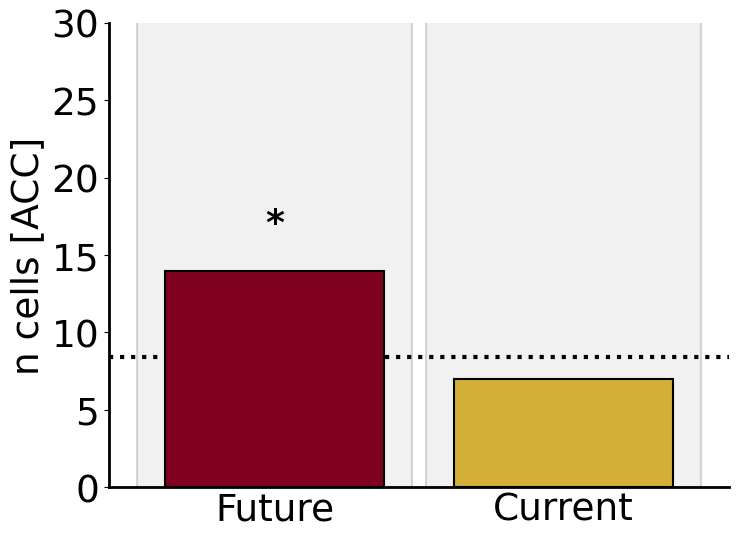

Future: k=14/168 | p=0.0432
Current: k=7/168 | p=0.7398
Chance level line = 8.40 cells (alpha=0.05)


In [133]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import binomtest

# ---- Inputs ----
alpha = 0.05
no_all_cells_ACC = 168
chance_level = alpha * no_all_cells_ACC  # expected count = 8.4

k_future = 14
k_current = 7
labels = ['Future', 'Current']

# ---- Binomial tests vs 168 ----
bt_future = binomtest(k_future, no_all_cells_ACC, p=alpha, alternative='greater')
bt_current = binomtest(k_current, no_all_cells_ACC, p=alpha, alternative='greater')

def stars(p):
    if p > 0.05: return ''
    if p > 0.01: return '*'
    if p > 0.001: return '**'
    return '***'

pvals = [bt_future.pvalue, bt_current.pvalue]
star_text = [stars(p) for p in pvals]

# ---- Aesthetics ----
mpl.rcParams.update({
    'font.size': 27,
    'axes.labelsize': 27,
    'xtick.labelsize': 27,
    'ytick.labelsize': 27,
    'axes.linewidth': 2
})

fig, ax = plt.subplots(figsize=(8,6))
bar_width = 0.95


# Background total bar (fixed at 168)
ax.bar(['Future', 'Current'],
       [no_all_cells_ACC, no_all_cells_ACC],
       color='lightgray', alpha=0.3,
       edgecolor='gray', linewidth=1.5,
       width=bar_width)

# Foreground significant bars (burgundy & yellow)
colors = ['#800020', '#D4AF37']
ax.bar(labels, [k_future, k_current],
       color=colors, edgecolor='black',
       linewidth=1.5, width=bar_width*0.8, zorder=3)

# Dotted chance line
ax.axhline(chance_level, linestyle=':', linewidth=3, color='black', zorder=2)

# Add significance stars
offset = 2.0
for x, (k, s) in enumerate(zip([k_future, k_current], star_text)):
    if s:
        ax.text(x, k + offset, s, ha='center', va='bottom',
                fontsize=26, fontweight='bold')

# Axes setup
ax.set_ylabel('n cells [ACC]')
ax.set_ylim(0, 30)            # zoomed-in to make differences visible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', length=0)

plt.tight_layout()
plt.show()

print(f"Future: k={k_future}/168 | p={bt_future.pvalue:.4f}")
print(f"Current: k={k_current}/168 | p={bt_current.pvalue:.4f}")
print(f"Chance level line = {chance_level:.2f} cells (alpha={alpha})")


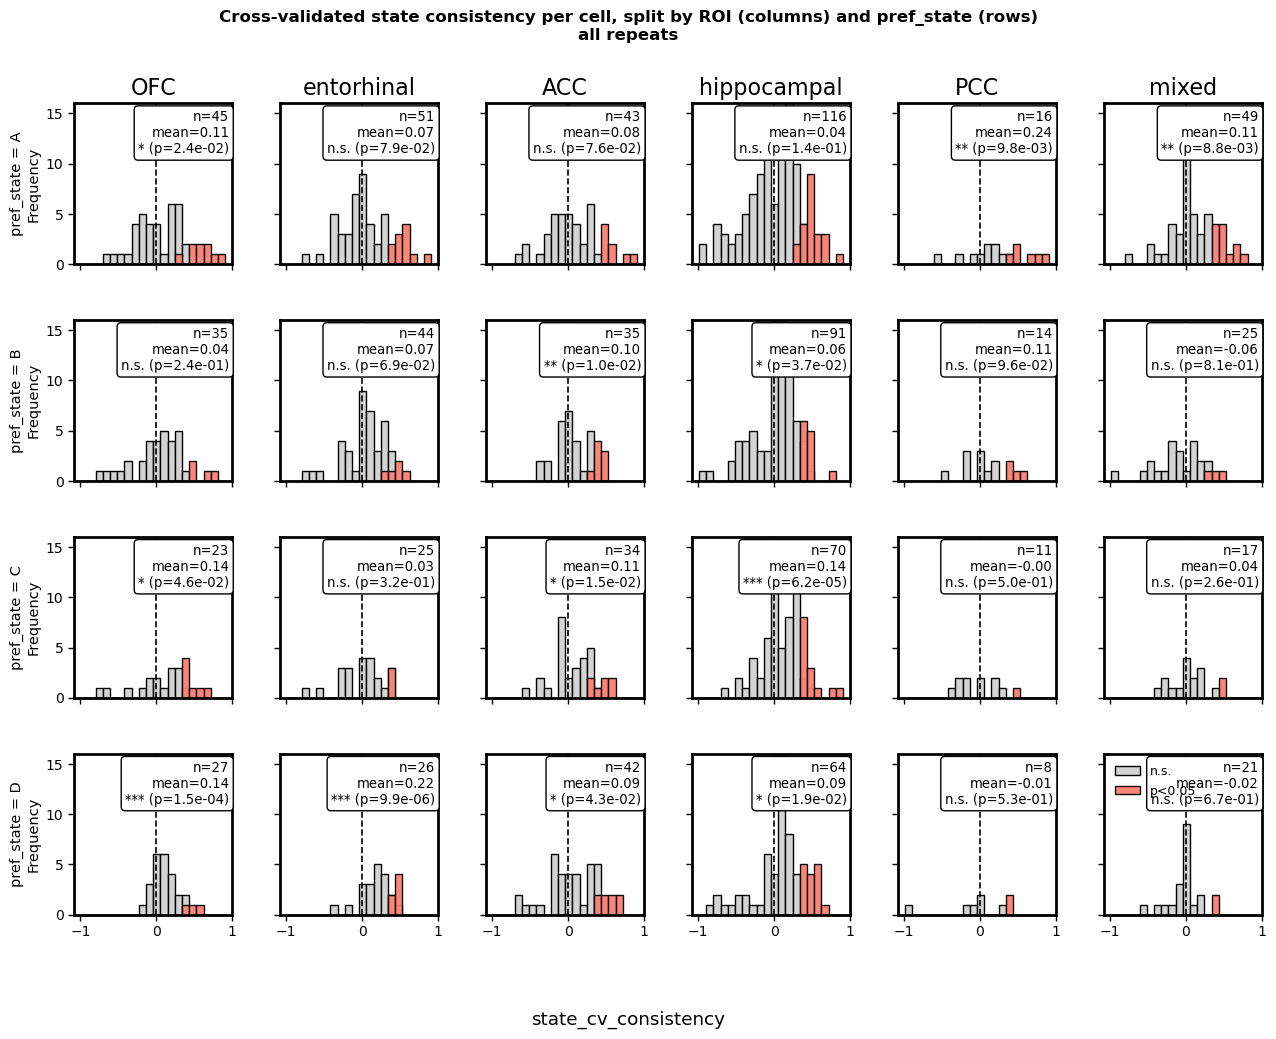

155 in EC
133 in OFC


In [134]:
path = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/state_tuning'
#file = 'pval_for_perms200_state_consistency_residualised_repeats_excl_gridwise_qc_pct_neurons.csv'
file = 'pval_for_perms200_state_consistency_all_minus_explore_repeats_excl_gridwise_qc_pct_neurons.csv'

pval_df = pd.read_csv(f"{path}/{file}")

title = 'all repeats'
mc.plotting.results.plot_results_per_roi_and_prefstate(pval_df, title)

sig_state_cells = pval_df[pval_df['p_perm']<0.05]
top_sig_state_cells = sig_state_cells.sort_values(by="state_cv_consistency", ascending=False).head(20)
sessions_to_load = top_sig_state_cells['session_id'].unique()


n_cells_EC = len(pval_df[pval_df['roi']=='entorhinal'])
print(f"{n_cells_EC} in EC")
n_cells_OFC = len(pval_df[pval_df['roi']=='OFC'])
print(f"{n_cells_OFC} in OFC")

In [123]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import binomtest

# =========================
# REQUIRED INPUTS
# =========================
# sig_state_cells: DataFrame with at least columns:
#   'roi'          -> 'EC' or 'ACC'
#   'pref_state'   -> 'A','B','C','D' (only significant cells should be here)
#
# total_cells: dict with total # of cells for each ROI
#   e.g., total_cells = {'EC': N_EC, 'ACC': 168}

alpha = 0.05
letters = ['A', 'B', 'C', 'D']
state_colors = {'A': '#F15A29', 'B': '#F7931E', 'C': '#C7C6E2', 'D': '#6B60AA'}

# -------------------------
# VISUAL STYLE (large fonts)
# -------------------------
mpl.rcParams.update({
    'font.size': 24,
    'axes.labelsize': 26,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'axes.linewidth': 2,
})

def _stars(p):
    if p > 0.05: return ''
    if p > 0.01: return '*'
    if p > 0.001: return '**'
    return '***'

def _contrast_text_color(hex_color):
    """Pick black/white text for good contrast on a given hex fill."""
    hc = hex_color.lstrip('#')
    r, g, b = tuple(int(hc[i:i+2], 16) for i in (0, 2, 4))
    # luminance
    L = 0.2126*(r/255)**2.2 + 0.7152*(g/255)**2.2 + 0.0722*(b/255)**2.2
    return 'black' if L > 0.6 else 'white'

def plot_roi_sig_stacks(sig_state_cells, total_cells, alpha=0.05, rois=('EC', 'ACC'),
                        figsize=(7.0, 6.0), ylim=None):
    """
    One stacked bar per ROI:
      - grey background bar = total cells in ROI
      - stacked colored bar = significant cells split by preferred state (A-D)
      - dotted line = chance level (alpha * total cells), per ROI
      - stars above if binomial test (k_sig vs N, p=alpha, one-sided greater) is significant
    """
    fig, ax = plt.subplots(figsize=figsize)

    x_positions = np.arange(len(rois))
    bar_width = 0.8

    # background bars (total cells)
    totals = [total_cells[r] for r in rois]
    ax.bar(x_positions, totals, width=bar_width, color='lightgray', alpha=0.35,
           edgecolor='gray', linewidth=1.8, zorder=0)

    # foreground stacked bars (significant by preferred state)
    top_heights = np.zeros(len(rois), dtype=float)
    binom_pvals = []
    k_sigs = []

    for i, roi in enumerate(rois):
        roi_total = total_cells[roi]
        # counts of significant cells by preferred state
        sub = sig_state_cells[sig_state_cells['roi'] == roi]
        counts = {s: int((sub['pref_state'] == s).sum()) for s in letters}
        k_sig = sum(counts.values())
        k_sigs.append(k_sig)

        # stack in A,B,C,D order
        for s in letters:
            h = counts[s]
            if h > 0:
                ax.bar(i, h, bottom=top_heights[i], width=bar_width*0.8,
                       color=state_colors[s], edgecolor='black', linewidth=1.2, zorder=3)
                # label the segment with the letter
                cy = top_heights[i] + h/2
                ax.text(i, cy, s, ha='center', va='center',
                        color=_contrast_text_color(state_colors[s]),
                        fontsize=24, fontweight='bold', zorder=4)
                top_heights[i] += h

        # per-ROI binomial test (is proportion > alpha?)
        bt = binomtest(k_sig, roi_total, p=alpha, alternative='greater')
        binom_pvals.append(bt.pvalue)

        # dotted chance line
        chance = alpha * roi_total
        ax.axhline(chance, xmin=(i-0.45)/max(1, len(rois)-1) if len(rois)>1 else 0.1,
                   xmax=(i+0.45)/max(1, len(rois)-1) if len(rois)>1 else 0.9,
                   linestyle=':', linewidth=2.5, color='black')

    # add significance stars
    for i, (k_sig, pval) in enumerate(zip(k_sigs, binom_pvals)):
        s = _stars(pval)
        if s:
            ax.text(i, top_heights[i] + max(1.0, 0.03*max(totals)), s,
                    ha='center', va='bottom', fontsize=30, fontweight='bold')

    # axes cosmetics
    ax.set_xticks(x_positions)
    ax.set_xticklabels(rois)
    ax.set_ylabel('n cells')
    # y-limit: either user-given, or auto with headroom for stars
    ymax = max(totals) if ylim is None else ylim[1]
    if ylim is None:
        ax.set_ylim(0, ymax*1.15)
    else:
        ax.set_ylim(*ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', length=0)
    plt.tight_layout()
    return fig, ax


# =========================
# EXAMPLE USAGE
# =========================
# total_cells must be provided per ROI:
# total_cells = {'EC': <N_EC>, 'ACC': 168}
# sig_state_cells must contain only *significant* cells (already filtered),
# with columns 'roi' ('EC'/'ACC') and 'pref_state' ('A'/'B'/'C'/'D').

# Example:
# fig, ax = plot_roi_sig_stacks(sig_state_cells, total_cells={'EC': N_EC, 'ACC': 168}, alpha=0.05,
#                               rois=('EC','ACC'), figsize=(7.5,6.5), ylim=(0, 35))
# plt.show()


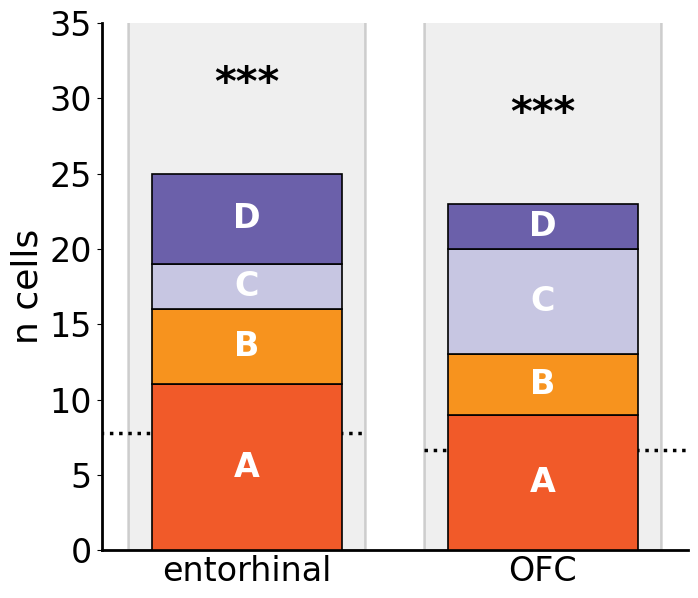

In [124]:
fig, ax = plot_roi_sig_stacks(sig_state_cells, total_cells={'entorhinal': n_cells_EC, 'OFC': n_cells_OFC}, alpha=0.05,rois=('entorhinal','OFC'), figsize=(7.5,6.5), ylim=(0, 35))
plt.show()


In [135]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import binomtest

# =========================
# REQUIRED INPUTS
# =========================
# sig_state_cells: DataFrame with at least columns:
#   'roi'          -> 'EC' or 'ACC'
#   'pref_state'   -> 'A','B','C','D' (only significant cells should be here)
#
# total_cells: dict with total # of cells for each ROI
#   e.g., total_cells = {'EC': N_EC, 'ACC': 168}

alpha = 0.05
letters = ['A', 'B', 'C', 'D']
state_colors = {'A': '#F15A29', 'B': '#F7931E', 'C': '#C7C6E2', 'D': '#6B60AA'}

# -------------------------
# VISUAL STYLE (large fonts)
# -------------------------
mpl.rcParams.update({
    'font.size': 24,
    'axes.labelsize': 26,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'axes.linewidth': 2,
})

def _stars(p):
    if p > 0.05: return ''
    if p > 0.01: return '*'
    if p > 0.001: return '**'
    return '***'

def _format_p(p):
    if p < 1e-3:
        return "< 0.001"
    elif p < 0.01:
        return f"= {p:.3f}"
    else:
        return f"= {p:.3f}"

def _contrast_text_color(hex_color):
    """Pick black/white text for good contrast on a given hex fill."""
    hc = hex_color.lstrip('#')
    r, g, b = tuple(int(hc[i:i+2], 16) for i in (0, 2, 4))
    L = 0.2126*(r/255)**2.2 + 0.7152*(g/255)**2.2 + 0.0722*(b/255)**2.2
    return 'black' if L > 0.6 else 'white'

def plot_roi_sig_stacks(sig_state_cells, total_cells, alpha=0.05, rois=('EC', 'ACC'),
                        figsize=(7.0, 6.0), ylim=None, print_report=True):
    """
    One stacked bar per ROI:
      - grey background bar = total cells in ROI
      - stacked colored bar = significant cells split by preferred state (A-D)
      - dotted line = chance level (alpha * total cells), per ROI
      - stars above if binomial test (k_sig vs N, p=alpha, one-sided greater) is significant

    Returns
    -------
    fig, ax, report_strings
      report_strings: dict {roi: "<clean text ready for manuscript>"}
    """
    fig, ax = plt.subplots(figsize=figsize)

    x_positions = np.arange(len(rois))
    bar_width = 0.8

    # background bars (total cells)
    totals = [total_cells[r] for r in rois]
    ax.bar(x_positions, totals, width=bar_width, color='lightgray', alpha=0.35,
           edgecolor='gray', linewidth=1.8, zorder=0)

    # foreground stacked bars (significant by preferred state)
    top_heights = np.zeros(len(rois), dtype=float)
    binom_pvals = []
    k_sigs = []
    chance_levels = []
    state_breakdowns = {}  # for reporting
    report_strings = {}

    for i, roi in enumerate(rois):
        roi_total = int(total_cells[roi])
        # counts of significant cells by preferred state
        sub = sig_state_cells[sig_state_cells['roi'] == roi]
        counts = {s: int((sub['pref_state'] == s).sum()) for s in letters}
        k_sig = sum(counts.values())
        k_sigs.append(k_sig)
        state_breakdowns[roi] = counts

        # stack A,B,C,D
        for s in letters:
            h = counts[s]
            if h > 0:
                ax.bar(i, h, bottom=top_heights[i], width=bar_width*0.8,
                       color=state_colors[s], edgecolor='black', linewidth=1.2, zorder=3)
                cy = top_heights[i] + h/2
                ax.text(i, cy, s, ha='center', va='center',
                        color=_contrast_text_color(state_colors[s]),
                        fontsize=24, fontweight='bold', zorder=4)
                top_heights[i] += h

        # per-ROI binomial test (is proportion > alpha?)
        bt = binomtest(k_sig, roi_total, p=alpha, alternative='greater')
        binom_pvals.append(bt.pvalue)

        # dotted chance line (draw just across the bar width in data coords)
        chance = alpha * roi_total
        chance_levels.append(chance)
        ax.plot([i - bar_width/2, i + bar_width/2], [chance, chance],
                linestyle=':', linewidth=2.5, color='black')

        # --- assemble report text for this ROI ---
        prop = (k_sig / roi_total) * 100.0 if roi_total > 0 else np.nan
        ptxt = _format_p(bt.pvalue)
        counts_txt = ", ".join([f"{s}={counts[s]}" for s in letters if counts[s] > 0]) or "none"
        report_strings[roi] = (
            f"{roi}: {k_sig} of {roi_total} cells ({prop:.1f}%) exceeded chance "
            f"(α = {alpha:.2f}; chance = {chance:.1f} cells); "
            f"one-sided binomial test, p {ptxt}. "
            f"Breakdown by preferred state: {counts_txt}."
        )

    # add significance stars
    for i, (k_sig, pval) in enumerate(zip(k_sigs, binom_pvals)):
        s = _stars(pval)
        if s:
            ax.text(i, top_heights[i] + max(1.0, 0.03*max(totals)), s,
                    ha='center', va='bottom', fontsize=30, fontweight='bold')

    # axes cosmetics
    ax.set_xticks(x_positions)
    ax.set_xticklabels(rois)
    ax.set_ylabel('n cells')
    ymax = max(totals) if ylim is None else ylim[1]
    if ylim is None:
        ax.set_ylim(0, ymax*1.15)
    else:
        ax.set_ylim(*ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', length=0)
    plt.tight_layout()

    if print_report:
        print("\n--- Text to report (copy-paste) ---")
        for roi in rois:
            print(report_strings[roi])

    return fig, ax, report_strings

# =========================
# EXAMPLE USAGE
# =========================
# total_cells = {'EC': N_EC, 'ACC': 168}
# sig_state_cells: DataFrame with rows = significant cells only,
# columns 'roi' ('EC'/'ACC') and 'pref_state' in {'A','B','C','D'}.
# fig, ax, report = plot_roi_sig_stacks(sig_state_cells, total_cells, alpha=0.05,
#                                       rois=('EC','ACC'), figsize=(7.5,6.5), ylim=(0, 40))
# plt.show()
# print(report['ACC'])  # if you want one ROI’s line



--- Text to report (copy-paste) ---
entorhinal: 25 of 155 cells (16.1%) exceeded chance (α = 0.05; chance = 7.8 cells); one-sided binomial test, p < 0.001. Breakdown by preferred state: A=11, B=5, C=3, D=6.
OFC: 23 of 133 cells (17.3%) exceeded chance (α = 0.05; chance = 6.7 cells); one-sided binomial test, p < 0.001. Breakdown by preferred state: A=9, B=4, C=7, D=3.


ValueError: too many values to unpack (expected 2)

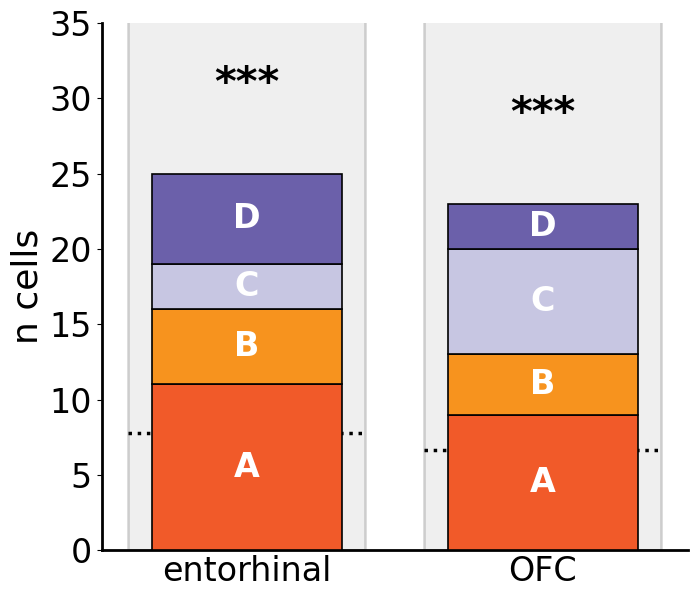

In [136]:
fig, ax = plot_roi_sig_stacks(sig_state_cells, total_cells={'entorhinal': n_cells_EC, 'OFC': n_cells_OFC}, alpha=0.05,rois=('entorhinal','OFC'), figsize=(7.5,6.5), ylim=(0, 35))
plt.show()